<a href="https://colab.research.google.com/github/Bibhash123/Estimation-of-Surface-NO2/blob/main/Notebooks/NO2_Ireland_Dataset(Proposed).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q kaggle
from google.colab import files
_ = files.upload()
!mkdir ~/.kaggle/
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d bibhash123/ireland2021
!unzip ireland2021.zip -d "/content/dataset"
!rm ireland2021.zip
from IPython.display import clear_output
clear_output(wait=False)

In [ ]:
!pip uninstall -y shapely
!pip uninstall -y cartopy
!pip install shapely cartopy --no-binary shapely --no-binary cartopy
clear_output(wait=False)

In [ ]:
# import sys
# del sys.modules["utils"]

In [ ]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import utils

SEED=123
def seedAll(seed):
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(seed)
  os.environ["PYTHONHASHSEED"]=str(seed)

seedAll(SEED)

In [ ]:
files = pd.read_csv("/content/dataset/files.csv").sample(frac=1).reset_index(drop=True)

In [ ]:
# from sklearn.model_selection import KFold
# kf = KFold(n_splits=5,shuffle=True)
# files.loc[:,'Fold'] = -1

# for fold,(i_trn,i_val) in enumerate(kf.split(files)):
#   files.loc[i_val,"Fold"] = fold

# files.to_csv("files.csv",index=False)
# !rm -r "/content/dataset/files.csv"
# !cp "files.csv" "/content/dataset/files.csv"
# !kaggle datasets init -p "/content/dataset"
# _ = input("Press any Key to continue")
# !kaggle datasets version -p "/content/dataset" --dir-mode tar -m "Update"
# # train_files,val_files = train_test_split(files,test_size=0.2)

In [ ]:
def pearson(y_true,y_pred):
  if len(y_true.shape)!=1:
    true = []
    for i in range(y_true.shape[0]):
      true.extend(y_true[i])
    pred = []
    for i in range(y_pred.shape[0]):
      pred.extend(y_pred[i])
  else:
    true=y_true
    pred=y_pred
  return np.mean((np.array(true)-np.mean(true))*(np.array(pred)-np.mean(pred)))/(np.std(np.array(true))*np.std(np.array(pred)))

def pearsonCorrAvgDays(true,pred):
  # assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

def pearsonCorrAvgPixels(true,pred):
  scores = []
  for i in range(true.shape[1]):
    scores.append(pearson(true[:,i],pred[:,i]))
  return np.mean(scores),scores

# Univariate

In [ ]:
def loadData(df,satdir = "/content/dataset/satellite/",gdir = "/content/dataset/ground/"):
  X = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = np.expand_dims(factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i])),axis=2)      
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      if not np.std(ground)==0:
        X.append(sat)
        Y.append(ground)
  return np.stack(X,axis=0),np.stack(Y,axis=0)

In [ ]:
def build_model(X_train):
  inp = L.Input(shape=X_train[0].shape)
  h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.Conv2D(32,(3,3),activation="linear")(h)
  out = L.Flatten()(h)
  out = L.Dense(100,activation="linear")(out)
  out = L.Dense(np.prod(X_train[0].shape),activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",
                metrics=[RootMeanSquaredError()])
  
  return model

In [ ]:
scores_list = []
rmses = []

for fold in range(5):
  print("\nFold {}\n".format(fold))
  train_files = files[files["Fold"]!=fold]
  val_files = files[files["Fold"]==fold]

  X_train,Y_train = loadData(train_files)
  X_val,Y_val = loadData(val_files)
  # loss_plt = utils.loss_plt()
  K.clear_session()
  model = build_model(X_train)
  if fold==0:
    print(model.summary())
  ckpt = ModelCheckpoint(f"model_{fold}.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
  model.fit(X_train,Y_train,
            epochs=50,
            verbose=0,
            batch_size=8,
            validation_data = (X_val,Y_val),
            callbacks=[ckpt])
  model.load_weights(f"model_{fold}.hdf5")
  rmse = mean_squared_error(Y_val,model.predict(X_val),squared=False)
  rmses.append(rmse)
  print("Fold {} RMSE Score: {}".format(fold, rmse))
  s,ls = pearsonCorrAvgDays(Y_val,model.predict(X_val))
  print("Fold {} Pearson coeff avg over days: {}".format(fold,np.mean([i for i in ls if not pd.isnull(i)])))
  scores_list.append(ls)
print("\nCV RMSE Score: {}".format(np.mean(rmses)))


Fold 0

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 49, 67, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 49, 67, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 47, 65, 16)        2320      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 63, 32)        4640      
_________________________________________________________________
flatten (Flatten)            (None, 90720)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               9072100   
_________________________________________________________________
dense_1 (Dense)              (None, 3283)           

In [ ]:
print("CV Pearson's average: {}".format(np.mean([0.6330227322165223,0.6409053204048945,0.6781420896754429,0.6487949096150153,0.6422253069466638])))

CV Pearson's average: 0.6486180717717078


In [ ]:
os.path.getsize("/content/model.hdf5")/(1024*1024)

35.9205436706543

In [ ]:
ireland_bound = [-9.4003, -6.032, 51.828500000000005, 54.323] #Irealand Extent
llcrn,urcrn = (-9.4003,51.8285),(-6.032,54.323) # Ireland bounds
# llcrn,urcrn = (-6.37,53.282),(-6.11,53.47) # dublin bounds
num_cols = int((urcrn[0]-llcrn[0])//0.05)
num_rows = int((urcrn[1]-llcrn[1])//0.05)
lat_cords = np.linspace(llcrn[1],urcrn[1]+0.05,num_rows)
lon_cords = np.linspace(llcrn[0],urcrn[0]+0.05,num_cols)
lon,lat = np.meshgrid(lon_cords,lat_cords)
import utils

In [ ]:
model.save_weights("eot.hdf5")

In [ ]:
model.load_weights("model.hdf5")

In [ ]:
pred = model.predict(np.stack([X_val[10]]))[0].reshape((X_train[0].shape[0],X_train[0].shape[1]))
true = Y_val[10].reshape((X_train[0].shape[0],X_train[0].shape[1]))

# Scores:
11.98: 
<pre>
inp = L.Input(shape=(18,25,1),)
  h = L.Conv2D(16,(3,3),activation="linear",padding="same")(inp)
  h = L.Conv2D(16,(3,3),activation="linear")(h)
  h = L.Conv2D(32,(3,3),activation="linear")(h)
  out = L.Flatten()(h)
  out = L.Dense(18*25,activation="linear")(out)
  model = Model(inputs=inp,outputs=out)
  model.compile(optimizer=Adam(learning_rate=0.001),loss="mse",metrics=[RootMeanSquaredError()])
</pre>

In [ ]:
print("RMSE Score: {}".format(mean_squared_error(Y_val,model.predict(X_val),squared=False)))

RMSE Score: 6.8111289136452235


In [ ]:
print("Pearson coeffiecient: {}".format(pearson(Y_val,model.predict(X_val))))

Pearson coeffiecient: 0.512067684895169


In [ ]:
s,ls = pearsonCorrAvgDays(Y_val,model.predict(X_val))
print("Pearson coeff avg over days: {}".format(np.mean([i for i in ls if not pd.isnull(i)])))

Pearson coeff avg over days: 0.6382245855191014


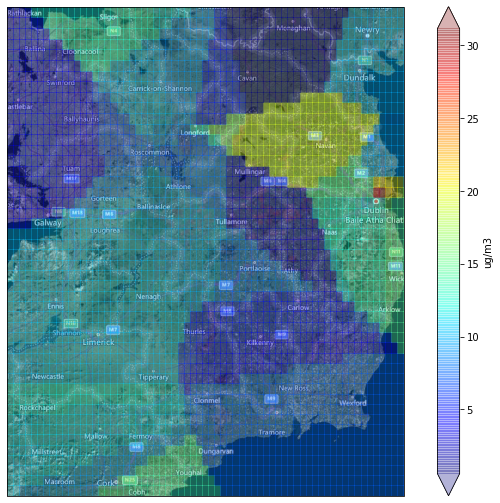

In [ ]:
utils.plotMap(pred,lon,lat,ireland_bound)

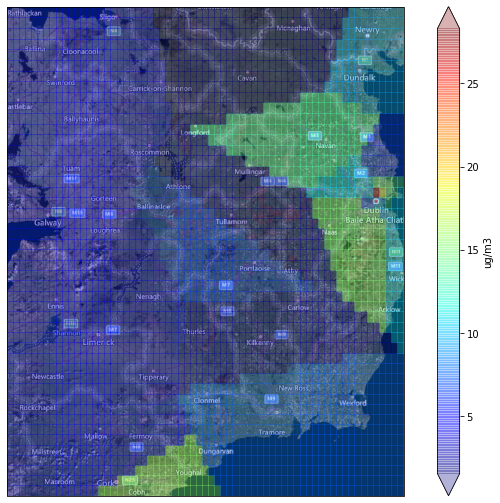

In [ ]:
utils.plotMap(true,lon,lat,ireland_bound)

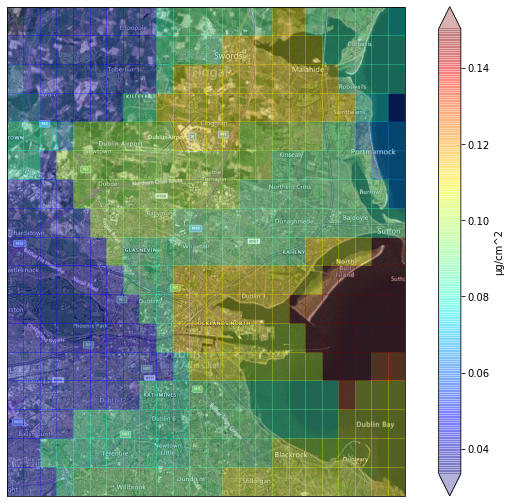

In [ ]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image

def nMap(grid,lon,lat):
  
  def image_spoof(self, tile): # this function pretends not to be a Python script
    url = self._image_url(tile) # get the url of the street map API
    req = Request(url) # start request
    req.add_header('User-agent','Anaconda 3') # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read()) # get image
    fh.close() # close url
    img = Image.open(im_data) # open image with PIL
    img = img.convert(self.desired_tile_form) # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

  cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
  osm_img = cimgt.QuadtreeTiles() # spoofed, downloaded street map

  fig = plt.figure(figsize=(12,9)) # open matplotlib figure
  ax1 = plt.axes(projection=osm_img.crs) # project using coordinate reference system (CRS) of street map
  zoom = 0.00075 # for zooming out of center point
  extent = [np.min(lon),np.max(lon),np.min(lat),np.max(lat)] # adjust to zoom
  #extent = [-6.4,-6.11,53.282,53.4]
  ax1.set_extent(extent) # set extents

  scale = np.ceil(-np.sqrt(2)*np.log(np.divide((extent[1]-extent[0])/2,350.0))) # empirical solve for scale based on zoom
  scale = (scale<20) and scale or 19# scale cannot be larger than 19
  ax1.add_image(osm_img, int(scale))# add OSM with zoom specification
  # NOTE: zoom specifications should be selected based on extent:
  # -- 2     = coarse image, select for worldwide or continental scales
  # -- 4-6   = medium coarseness, select for countries and larger states
  # -- 6-10  = medium fineness, select for smaller states, regions, and cities
  # -- 10-12 = fine image, select for city boundaries and zip codes
  # -- 14+   = extremely fine image, select for roads, blocks, buildings
  my_cmap = plt.cm.get_cmap("jet")
  c = plt.pcolormesh(lon,lat,grid,transform=ccrs.PlateCarree(),cmap=my_cmap,alpha=0.3)
  fig.colorbar(c,ax=ax1,label="μg/cm^2",extend="both")
  plt.show() # show the plot
nMap(X_val[0,:,:,0],lon,lat)

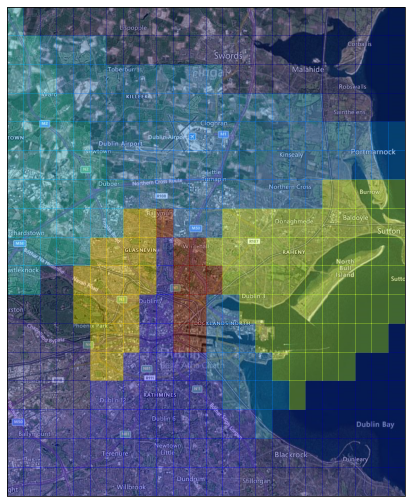

In [ ]:
# utils.plotMap(pred,lon,lat)

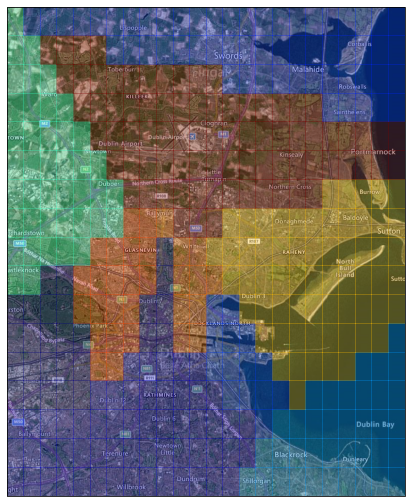

In [ ]:
# utils.plotMap(true,lon,lat)

(-0.5, 1411.5, 805.5, -0.5)

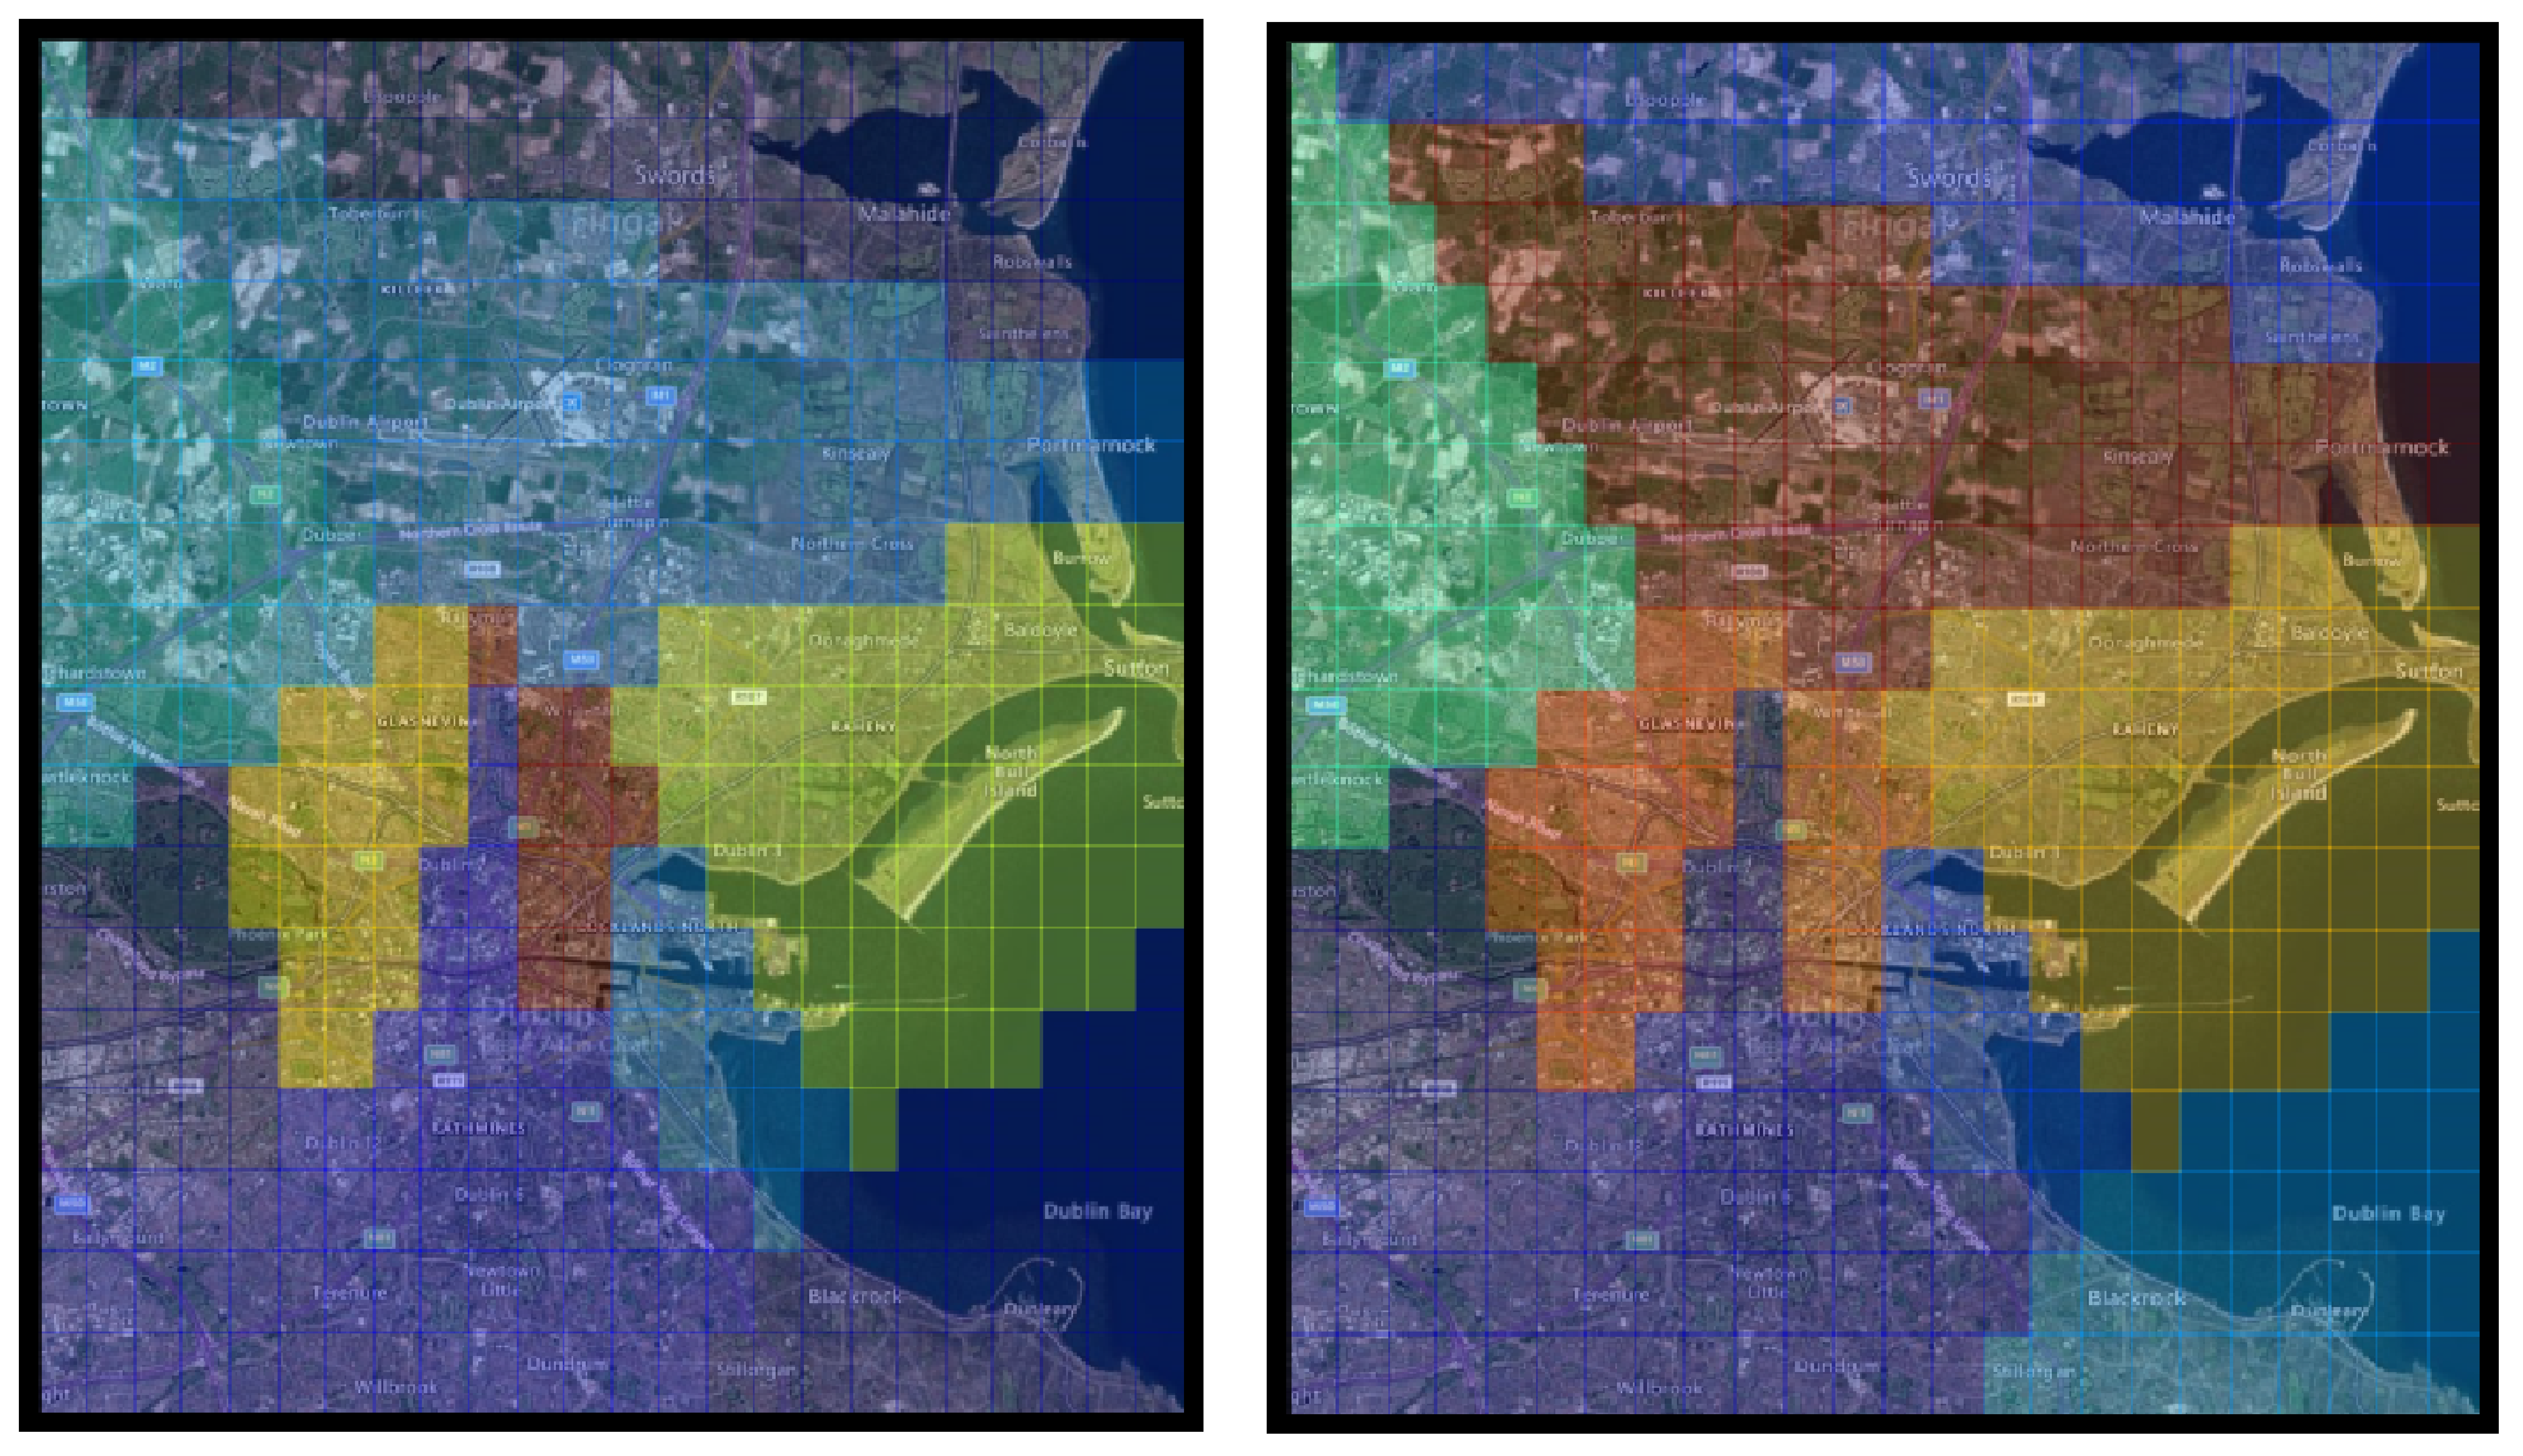

In [ ]:
plt.figure(figsize=(17,25),dpi=600);
plt.imshow(plt.imread("/content/comparision.png"))
plt.axis("off")

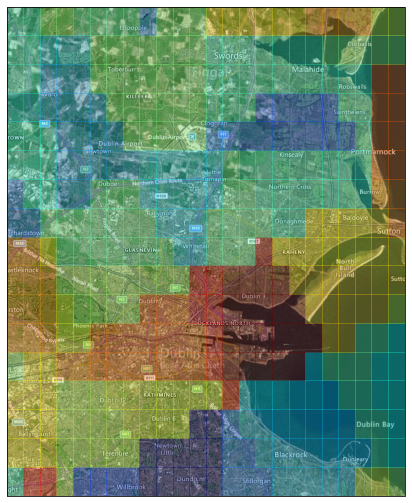

In [ ]:
utils.plotMap(X_val[0,:,:,0],lon,lat)

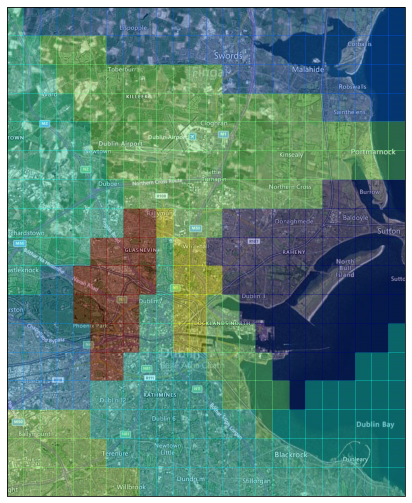

In [ ]:
i = np.load(os.path.join("/content/dataset/ground",files[files["Date"]=="2020-04-30"]["GroundFile"].values[0]))
utils.plotMap(i,lon,lat)

# With Altitude(stacked)

In [ ]:
def loadData(df,satdir = "/content/dataset/satellite/",gdir = "/content/dataset/ground/",altdir="/content/dataset/altitude/"):
  X_ = []
  X_alt = []
  Y = []
  for i in range(df.shape[0]):
    factor = 46*(6.02214/6.023)*1e2
    sat = factor*np.load(os.path.join(satdir,df["SatFile"].iloc[i]))
    alt =  np.load(os.path.join(altdir,df["AltGrid"].iloc[i]))    
    ground = np.load(os.path.join(gdir,df["GroundFile"].iloc[i])).flatten()
    if not np.isnan(np.sum(sat)) and not np.isnan(np.sum(ground)):
      X_.append(np.expand_dims(sat,axis=2))
      X_alt.append(np.expand_dims(alt,axis=2))
      Y.append(ground)
  return np.stack(X_,axis=0),np.stack(X_alt,axis=0),np.stack(Y,axis=0)

In [ ]:
X_train_sat,X_train_alt,Y_train = loadData(train_files)
X_val_sat,X_val_alt,Y_val = loadData(val_files)

In [ ]:
sc_sat = StandardScaler()
sc_alt = StandardScaler()

X_train_sat = sc_sat.fit_transform(X_train_sat[:,:,:,0].reshape(X_train_sat.shape[0],-1)).reshape((X_train_sat.shape[0],18,25,1))
X_train_alt = sc_alt.fit_transform(X_train_alt[:,:,:,0].reshape(X_train_alt.shape[0],-1)).reshape((X_train_alt.shape[0],18,25,1))

X_val_sat = sc_sat.transform(X_val_sat[:,:,:,0].reshape(X_val_sat.shape[0],-1)).reshape((X_val_sat.shape[0],18,25,1))
X_val_alt = sc_alt.transform(X_val_alt[:,:,:,0].reshape(X_val_alt.shape[0],-1)).reshape((X_val_alt.shape[0],18,25,1))

In [ ]:
def build_model():
  inp1 = L.Input(shape=(18,25,1))
  h1 = L.Conv2D(8,(3,3),activation="linear",padding="same")(inp1)
  h1 = L.Conv2D(8,(3,3),activation="linear")(h1)
  h1 = L.Conv2D(16,(3,3),activation="linear")(h1)
  out1 = L.Flatten()(h1)

  inp2 = L.Input(shape=(18,25,1))
  h2 = L.Conv2D(8,(3,3),activation="linear",padding="same")(inp2)
  h2 = L.Conv2D(8,(3,3),activation="linear")(h2)
  h2 = L.Conv2D(16,(3,3),activation="linear")(h2)
  out2 = L.Flatten()(h2)
  
  out = L.Concatenate()([out1,out2])
  out = L.Dense(18*25,activation="linear")(out)
  model = Model(inputs=[inp1,inp2],outputs=out)
  model.compile(optimizer=Adam(learning_rate=1e-4),loss="mse",metrics=[RootMeanSquaredError()])
  return model
  
K.clear_session()
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 18, 25, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 18, 25, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 18, 25, 8)    80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 18, 25, 8)    80          input_2[0][0]                    
______________________________________________________________________________________________

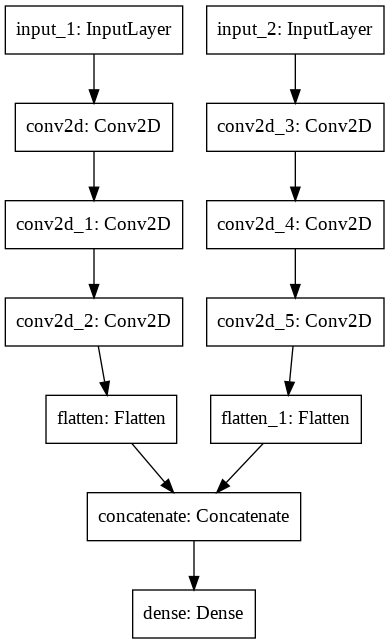

In [ ]:
tf.keras.utils.plot_model(model)

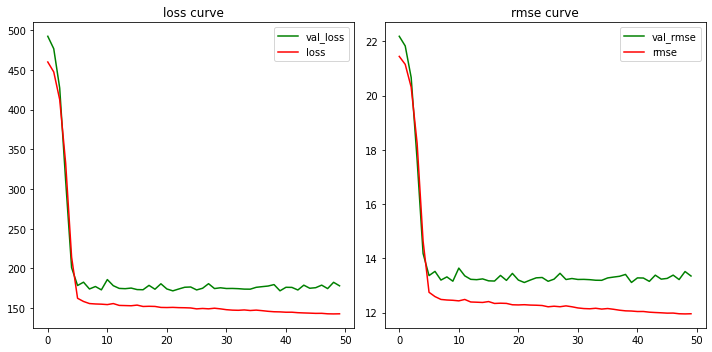

epoch 50/50 loss: 142.959 rmse: 11.9565 val_loss: 178.173 val_rmse:13.3481


In [ ]:
loss_plt = utils.loss_plt()
ckpt = ModelCheckpoint("model.hdf5",monitor="val_root_mean_squared_error",mode="min",save_best_only=True,save_weights_only=True)
model.fit((X_train_sat,X_train_alt),Y_train,
          epochs=50,
          batch_size=8,
          validation_data = ((X_val_sat,X_val_alt),Y_val),
          callbacks=[loss_plt,ckpt])

In [ ]:
llcrn,urcrn = (-6.37,53.282),(-6.11,53.47) # dublin bounds
num_cols = int((urcrn[0]-llcrn[0])//0.01)
num_rows = int((urcrn[1]-llcrn[1])//0.01)
lat_cords = np.linspace(llcrn[1],urcrn[1]+0.01,num_rows)
lon_cords = np.linspace(llcrn[0],urcrn[0]+0.01,num_cols)
lon,lat = np.meshgrid(lon_cords,lat_cords)
import utils
model.save_weights("eot.hdf5")

In [ ]:
model.load_weights("model.hdf5")

In [ ]:
pred = model.predict((np.expand_dims(X_val_sat[10],axis=0),np.expand_dims(X_val_alt[10],axis=0)))[0].reshape((18,25))
true = Y_val[10].reshape((18,25))

In [ ]:
print("RMSE Score: {}".format(mean_squared_error(Y_val,model.predict((X_val_sat,X_val_alt)),squared=False)))

RMSE Score: 13.108981831519667


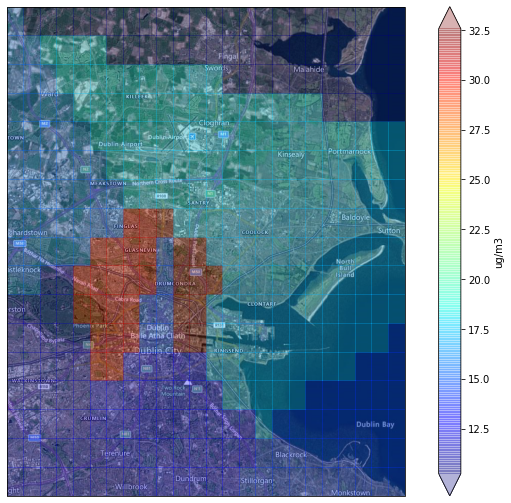

In [ ]:
utils.plotMap(pred,lon,lat)

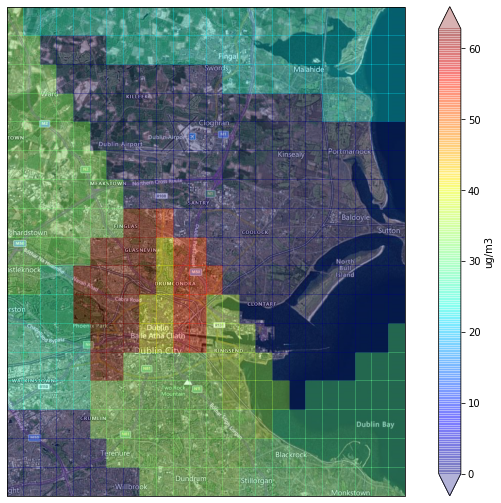

In [ ]:
utils.plotMap(true,lon,lat)

In [ ]:
def pearson(true,pred):
  return np.mean((true-np.mean(true))*(pred-np.mean(pred)))/(np.std(true)*np.std(pred))

In [ ]:
def pearsonCorr(true,pred):
  assert len(true.shape)>=3,"true must have at least 3 dimensions, found {}".format(len(true.shape))
  assert true.shape==pred.shape, "true and pred must have same shape, found {} and {}".format(true.shape,pred.shape)
  scores = []
  for i in range(true.shape[0]):
    scores.append(pearson(true[i],pred[i]))
  return np.mean(scores),scores

In [ ]:
mean,scores = pearsonCorr(Y_val.reshape(Y_val.shape[0],18,25),model.predict((X_val_sat,X_val_alt)).reshape(Y_val.shape[0],18,25))

In [ ]:
mean #averaged over days. Individual coeffs for single day.

0.5374554532810978

In [ ]:
flat_true = Y_val.flatten()
flat_pred = model.predict((X_val_sat,X_val_alt)).flatten()

In [ ]:
pearson(flat_true,flat_pred) #taken together for all pixel and all days

0.37214401943356173

In [ ]:
!git clone https://github.com/HSG-AIML/NO2-dataset.git

Cloning into 'NO2-dataset'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 42 (delta 17), reused 25 (delta 8), pack-reused 5
Unpacking objects: 100% (42/42), done.


In [ ]:
!cp "/content/NO2-dataset/no2_dataset.tar.gz" "no2_dataset.tar.gz"

In [ ]:
!rm -r "NO2-dataset"

In [ ]:
!mkdir "/content/NO2_dataset"
!tar -xvf "no2_dataset.tar.gz" -C "/content/NO2_dataset"

no2_dataset.csv


In [ ]:
os.path.getsize("/content/NO2_dataset/no2_dataset.csv")/(1024**2)

526.0370035171509

In [ ]:
pd.read_csv("NO2_dataset/no2_dataset.csv").shape

(1622453, 23)